In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('https://raw.githubusercontent.com/AgnaldoCC/previsao_cartola_2014/master/cartola_2014.csv')

df.head(10)


,atleta_id,rodada,clube_id,participou,posicao_id,jogos_num,pontos_num,media_num,preco_num,variacao_num,partida_id,mando,titular,substituido,tempo_jogado,nota,FS,PE,A,FT,FD,FF,G,I,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS
0,37958,1,262.0,1,1.0,1,8.0,8.0,19.69,1.69,179872.0,1,1.0,0,1.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,68873,1,262.0,0,1.0,0,0.0,0.0,4.00,0.00,179872.0,1,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,37701,1,262.0,1,2.0,1,0.4,0.4,16.97,-5.03,179872.0,1,1.0,0,1.0,6.0,0,7,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
3,71602,1,262.0,0,2.0,0,0.0,0.0,3.00,0.00,179872.0,1,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,37684,1,262.0,1,3.0,1,9.1,9.1,10.68,5.68,179872.0,1,1.0,0,1.0,6.0,2,1,0,0,1,0,0,1,0,2,1,0,0,0,1,0,0,0
5,68958,1,262.0,1,3.0,1,6.3,6.3,15.38,1.38,179872.0,1,1.0,0,1.0,6.0,1,1,0,0,0,1,0,0,0,2,2,0,1,0,1,0,0,0
6,81223,1,262.0,0,3.0,0,0.0,0.0,4.00,0.00,179872.0,1,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,38311,1,262.0,1,4.0,1,3.0,3.0,7.57,0.57,179872.0,1,1.0,0,1.0,6.0,2,3,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0
8,50301,1,262.0,1,4.0,1,1.8,1.8,14.24,-2.76,179872.0,1,1.0,0,1.0,5.5,2,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9,72071,1,262.0,1,4.0,1,-2.6,-2.6,1.06,-2.94,179872.0,1,1.0,1,0.5,4.0,0,1,0,0,0,1,0,0,0,0,2,0,1,0,0,0,0,0


1) Realize uma análise exploratória nos dados, identificando e explorando: (i) correlações entre as variáveis, (ii) distribuição das variáveis e (iii) valores ausentes

Dimensões originais dos dados:  (29184, 34)
Dimensão dos dados após as limpezas:  (9869, 34)


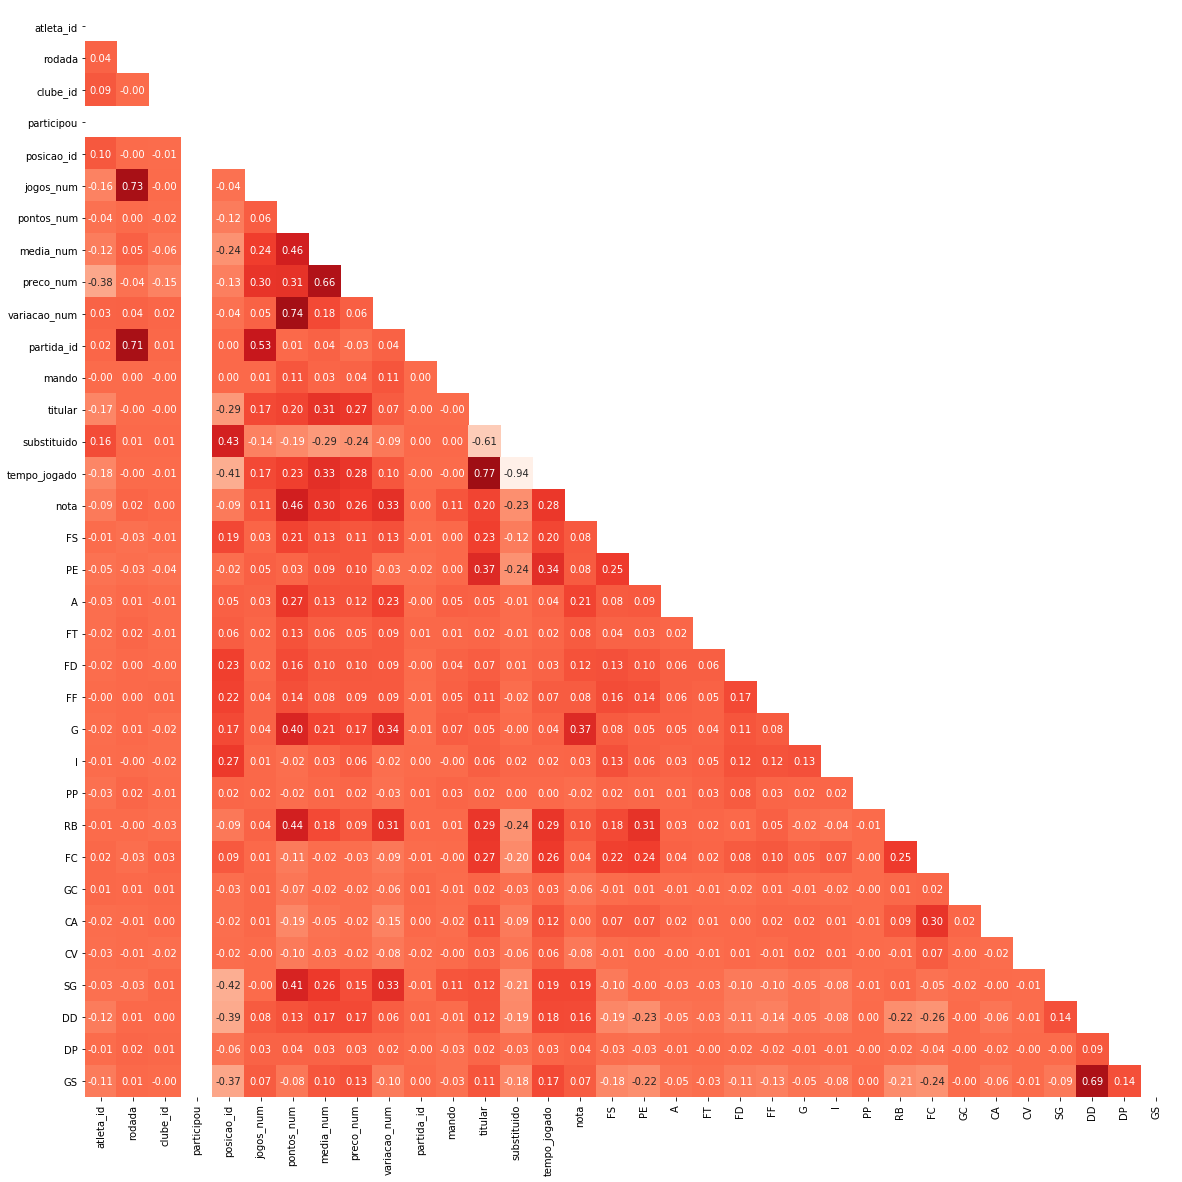

In [50]:
df_limpo = df.copy()


print("Dimensões originais dos dados: ", df.shape)

# Remove todos técnicos
df_limpo = df_limpo[df_limpo['posicao_id'] != 6]

# Remove todos os que são da posição id != 0
df_limpo = df_limpo[df_limpo['posicao_id'] != 0]

# Remove todos dados de jogadores que não participaram
df_limpo = df_limpo[df_limpo['participou'] == 1]

print("Dimensão dos dados após as limpezas: ", df_limpo.shape)
df_limpo.head(10)

correlacao = df_limpo.corr(method='spearman')
mascara = np.zeros_like(correlacao)
mascara[np.triu_indices_from(mascara)] = True

#Gráfico com a correlação entre as variáveis
fig, ax = plt.subplots()
ax.figure.set_size_inches(20, 20)
sns.heatmap(correlacao, ax=ax, annot=True, mask=mascara, fmt='.2f', cbar=False, square=True, cmap=plt.cm.Reds, center=0)

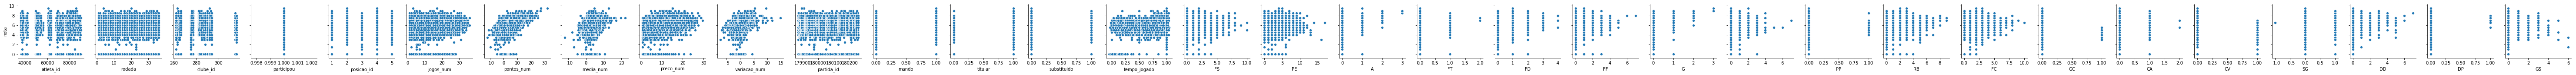

In [51]:
variaveis = list(df_limpo.columns)
variaveis.remove('nota')

sns.pairplot(df_limpo, x_vars=variaveis, y_vars='nota', palette="husl")
plt.show()

x_train = df_limpo.loc[:, df_limpo.columns != 'nota']
y_train = df_limpo.nota.values

2) Usando todas as variáveis disponíveis, tune (usando validação cruzada): (i) um modelo de regressão Ridge, (ii) um modelo de regressão Lasso e (iii) um modelo KNN. Para os modelos de regressão linear, o parâmetro a ser tunado é o lambda (penalização dos coeficientes) e no KNN o número (K) de vizinhos. Compare os três modelos em termos do erro RMSE de validação cruzada.

In [0]:
def rmse_validacao_cruzada(model):
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

Modelo Ridge com vários Alphas

Text(0, 0.5, 'rmse')

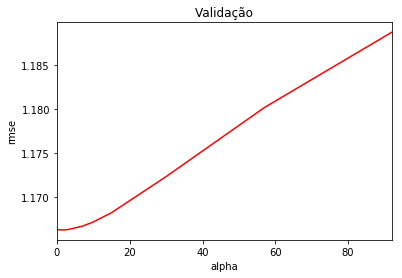

In [53]:
alphas = [0.0000001, 0.00001, 0.01, 0.05, 0.1, 0.3, 2, 3, 7, 10, 15, 30, 57, 92]
rigde_validadao_cruzada = [rmse_validacao_cruzada(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

rigde_validadao_cruzada = pd.Series(rigde_validadao_cruzada, index = alphas)
rigde_validadao_cruzada.plot(title = "Validação", color='red')
plt.xlabel("alpha")
plt.ylabel("rmse")

In [54]:
valor_minimo_ridge = rigde_validadao_cruzada.min()

print('Melhor parâmetro para o Ridge é ' + str(valor_minimo_ridge))

Melhor parâmetro para o Ridge é 1.166301165003413


In [58]:
lasso = LassoCV(alphas = [1.3, 0.9, 0.2, 0.1, 0.00001, 0.004505], cv=5).fit(x_train, y_train)

rmse_lasso = rmse_validacao_cruzada(lasso).mean()

alphas_lasso = [1.3, 0.9, 0.2, 0.1, 0.00001, 0.004505]

cv_lasso = [rmse_validacao_cruzada(Lasso(alpha = alpha)).mean() 
            for alpha in alphas_lasso]

cv_lasso = pd.Series(cv_lasso, index = alphas_lasso)

cv_lasso


#Como pode-se ver pela análise abaixo, o melhor valor para o Lasso é o 0.000010 pois foi o que apresentou o menor RMSE
print('Melhor parâmetro para o Lasso é ' + str(0.000010))

1.300000    1.366796
0.900000    1.344388
0.200000    1.303273
0.100000    1.273414
0.000010    1.166318
0.004505    1.170496
dtype: float64

In [62]:
vizinhos = [2, 8, 17, 22, 39]

cv_knn = [rmse_validacao_cruzada(KNeighborsRegressor(n_neighbors=vizinho)).mean() 
            for vizinho in vizinhos]

cv_knn = pd.Series(cv_knn, index = vizinhos)

#Como pode-se ver pela análise abaixo, o melhor valor para o KNN é o 0.000010 pois foi o que apresentou o menor RMSE

print('Melhor parâmetro para o Lasso é ' + str(0.000010)

Melhor parâmetro para o Lasso é 1.4550287967504065


In [63]:
valor_ridge = valor_minimo_ridge
valor_lasso = cv_lasso.min()
valor_knn = cv_knn.min()

print("Valor Ridge " + str(valor_ridge))
print("Valor Lasso " + str(valor_lasso))
print("Valor KNN " + str(valor_knn))



#Pela lista abaixo, podemos perceber que o melhor modelo para validação cruzada é o Ridge, pois tem o menor valor do RMSE.

Valor Ridge 1.166301165003413
Valor Lasso 1.1663181064732366
Valor KNN 1.4550287967504065
